<a href="https://colab.research.google.com/github/liangchow/zindi-amazon-secret-runway/blob/main/zindi_airstrip_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setup.

In [1]:
%%capture
!pip -q install rasterio
!pip -q install torch
!pip -q install torchvision
!pip -q install albumentations
!pip -q install segmentation-models-pytorch
!pip -q install tqdm

In [2]:
import os
import torch
import rasterio
import albumentations as A
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from torchvision import transforms as T
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.nn.functional as F
import torchsummary
from tqdm import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import numpy as np
from sklearn.metrics import f1_score

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Download training data to local compute node

## Mount your Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Compress training files, copy over and uncompress

In [4]:
# Navigate to the shared directory
%cd /content/drive/MyDrive/Zindi-Amazon/training
# Zip the data
!zip -r /content/images.zip images
!zip -r /content/masks.zip masks
!zip -r /content/masks_10m.zip masks_10m
!zip -r /content/masks_20m.zip masks_20m
!zip -r /content/masks_100m.zip masks_100m
!zip -r /content/masks_200m.zip masks_200m
# Unzip the files
!unzip /content/images.zip -d /content
!unzip /content/masks.zip -d /content
!unzip /content/masks_10m.zip -d /content
!unzip /content/masks_20m.zip -d /content
!unzip /content/masks_100m.zip -d /content
!unzip /content/masks_200m.zip -d /content

/content/drive/.shortcut-targets-by-id/14mw0v8Bi-MzhsqSI0K3KO23YrUHttM7P/Zindi-Amazon/training
  adding: images/ (stored 0%)
  adding: images/Sentinel_AllBands_Training_Id_59.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_61.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_78.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_79.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_105.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_120.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_135.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_176.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_157.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_148.tif (deflated 4%)
  adding: images/Sentinel_AllBands_Training_Id_17.tif (deflated 4%)
  adding: images/Sentinel_AllBands_Training_Id_99.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_172.ti

# Custom classes and functions to handle Sentinel 1/2 data and corresponding masks

In [5]:
# Custom Dataset class for Sentinel 1/2 bands and mask
class Sentinel2Dataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, additional_bands=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.additional_bands = additional_bands if additional_bands else []

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask using rasterio
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        with rasterio.open(image_path) as src:
            # Initialize dictionary for all required bands
            bands = {desc: src.read(i + 1) for i, desc in enumerate(src.descriptions) if desc in ['B4', 'B3', 'B2'] + self.additional_bands}

            # Ensure RGB bands B4, B3, and B2 are present
            if not all(band in bands for band in ['B4', 'B3', 'B2']):
                raise ValueError(f"RGB bands (B4, B3, B2) not found in image: {image_path}")

            # Normalize RGB bands (B4, B3, B2) only
            rgb_image = np.stack([bands['B4'], bands['B3'], bands['B2']], axis=-1)
            rgb_image = np.clip(rgb_image, 0, 2000) / 2000  # Scaling between 0 and 1

            # Stack additional bands without normalization
            other_band_images = [bands[band] for band in self.additional_bands]
            if other_band_images:
                full_image = np.concatenate([rgb_image] + [np.expand_dims(b, axis=-1) for b in other_band_images], axis=-1)
            else:
                full_image = rgb_image

        with rasterio.open(mask_path) as mask_src:
            mask = mask_src.read(1)

        # Ensure both image and mask are numpy arrays before applying transforms
        image = np.array(full_image)
        mask = np.array(mask)

        if check_for_nan_inf(image) or check_for_nan_inf(mask):
            raise ValueError(f"NaN or Inf values found in data: {image_path}, {mask_path}")

        # Apply any transformations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Only convert to PyTorch tensors if not already tensors (skip if the transform does it)
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(image).permute(2, 0, 1).float()  # Channels first
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).long()

        return image, mask


In [6]:
def check_for_nan_inf(data):
    """Checks for NaN or Inf values in NumPy data."""
    if np.isnan(data).any() or np.isinf(data).any():
        return True  # Found NaN or Inf
    else:
        return False  # No NaN or Inf


In [7]:
# Augmentations using albumentations and PyTorch's ToTensor
def get_augmentations(option='train', optional_bands=None):
    # Define mean and std for RGB (B4, B3, B2)
    base_band_means = {'B4': 0.485, 'B3': 0.456, 'B2': 0.406}
    base_band_stds = {'B4': 0.229, 'B3': 0.224, 'B2': 0.225}

    # Define mean and std for additional optional bands
    optional_band_means = {'B8': 2987.760, 'B11': 1656.303, 'B12': 729.068, 'VV': -8.048, 'VH': -14.456, 'VV_VH_Ratio': 0.547}
    optional_band_stds = {'B8': 504.165, 'B11': 314.123, 'B12': 203.183, 'VV': 1.911, 'VH': 1.825, 'VV_VH_Ratio': 0.064}

    # Combine base bands and optional bands
    all_band_means = {**base_band_means, **optional_band_means}
    all_band_stds = {**base_band_stds, **optional_band_stds}

    # If optional_bands is specified, get only those; otherwise, default to RGB
    selected_bands = ['B4', 'B3', 'B2'] + (optional_bands if optional_bands else [])
    mean = tuple(all_band_means[band] for band in selected_bands)
    std = tuple(all_band_stds[band] for band in selected_bands)

    # Define augmentation pipeline based on phase
    augmentations = {
        'train': [
            A.CropNonEmptyMaskIfExists(width=224, height=224),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
        ],
        'val': [
            A.CropNonEmptyMaskIfExists(width=224, height=224),
        ],
        'test': [
            A.CropNonEmptyMaskIfExists(width=224, height=224),
        ],
        'inference': [
            A.CenterCrop(width=224, height=224),
        ]
    }

    if option not in augmentations:
        raise ValueError("Invalid option. Choose from 'train', 'val', 'test', or 'inference'.")

    # Add normalization and tensor transformation
    augmentations[option].extend([
        A.Normalize(mean=mean, std=std, max_pixel_value=1.0),
        ToTensorV2(),
    ])

    # Return the Compose pipeline with additional mask target
    return A.Compose(augmentations[option], additional_targets={'mask': 'mask'})

#    if option == 'train':
#        return A.Compose([
#            #A.RandomCrop(width=224, height=224),
#            A.CropNonEmptyMaskIfExists(width=224, height=224),
#            A.HorizontalFlip(p=0.5),
#            A.VerticalFlip(p=0.5),
#            A.RandomRotate90(p=0.5),
#            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
#            #A.Resize(width=224, height=224),
#            ToTensorV2(),
#        ], additional_targets={'mask': 'mask'})
#    elif option == 'val':
#        return A.Compose([
#            #A.RandomCrop(height=224, width=224),  # Resize for validation
#            A.CropNonEmptyMaskIfExists(width=224, height=224),
#            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
#            ToTensorV2(),
#        ], additional_targets={'mask': 'mask'})
#    elif option == 'test':
#        return A.Compose([
#            #A.RandomCrop(height=224, width=224),  # Resize for testing
#            A.CropNonEmptyMaskIfExists(width=224, height=224),
#            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
#            ToTensorV2(),
#        ], additional_targets={'mask': 'mask'})
#    elif option == 'inference':
#        return A.Compose([
#            A.CenterCrop(width=224, height=224),
#            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
#            ToTensorV2(),
#        ], additional_targets={'mask': 'mask'})
#    else:
#        raise ValueError("Invalid option. Choose from 'train', 'val', or 'test'.")

In [8]:
# UNet model with ResNet50 encoder
def get_model(in_channels=3):
    model = smp.Unet(
        encoder_name='resnet50',        # Choose encoder, ResNet50 in this case
        encoder_weights='imagenet',     # Use pre-trained weights
        in_channels=in_channels,                  # RGB, modify later for more channels
        classes=1,                      # Binary segmentation
    )
    return model

In [9]:
# Training loop
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()

    total_loss = 0.0
    running_loss = 0.0
    running_total_pixels = 0.0
    running_correct_pixels = 0.0

    for batch_idx, (images, masks) in enumerate(tqdm(dataloader)):
        images = images.to(device)
        # Change data type of masks to float32 before moving to device
        masks = masks.type(torch.float32).to(device).unsqueeze(1)  # Add channel dimension to masks
        images = images.float()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        ## Next line is an attempt at limiting loss from exploding.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients to a maximum norm of 1
        optimizer.step()

        # Calculate per-pixel accuracy
        preds = torch.sigmoid(outputs) > 0.5  # Threshold to convert logits to binary predictions (for binary segmentation)
        correct_pixels = torch.sum(preds == masks).item()
        total_pixels = masks.numel()  # Total number of pixels in the batch

        # Calculate running loss and accuracy
        running_loss += loss.item() * images.size(0)
        running_correct_pixels += correct_pixels
        running_total_pixels += total_pixels

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = (running_correct_pixels / running_total_pixels) * 100  # Pixel-wise accuracy
    print(f"Train Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

    return epoch_loss, epoch_accuracy

In [10]:
def evaluate(model, dataloader, criterion, device, phase="val", plot=False):
    model.eval()

    running_loss = 0
    running_correct_pixels = 0
    total_iou = 0
    num_samples = 0
    running_total_pixels = 0
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0

    imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]


    for i, (images, masks) in enumerate(tqdm(dataloader)):
        images = images.to(device)
        masks = masks.to(device)

        # Add channel dimension to the target masks
        masks = masks.type(torch.float32)
        masks = masks.unsqueeze(1)


        with torch.set_grad_enabled(False):
            outputs = model(images)
            loss = criterion(outputs, masks)
            # Apply sigmoid to the outputs (for binary segmentation) and threshold
            preds = torch.sigmoid(outputs) > 0.5

        # Calculate per-pixel accuracy
        correct_pixels = torch.sum(preds == masks).item()
        total_pixels = masks.numel()
        running_correct_pixels += correct_pixels
        running_total_pixels += total_pixels

         # Calculate IoU and F1 score metrics
        for j in range(images.shape[0]):
            prediction = preds[j].squeeze(0)  # Remove channel dimension
            #prediction = (prediction > 0.5).float()  # Example threshold of 0.5
            iou = calculate_jaccard_index(prediction, masks[j])
            total_iou += iou

            # Calculate TP, FP, FN for F1 score
            true_positive = torch.sum((prediction == 1) & (masks[j] == 1)).item()
            false_positive = torch.sum((prediction == 1) & (masks[j] == 0)).item()
            false_negative = torch.sum((prediction == 0) & (masks[j] == 1)).item()

            total_true_positives += true_positive
            total_false_positives += false_positive
            total_false_negatives += false_negative
            num_samples += 1


        if plot:
            # Plot image, mask, and prediction for a sample in the batch
            for i in range(images.shape[0]):  # Loop through batch
                image = images[i].cpu().permute(1, 2, 0).numpy()  # Move to CPU, permute for plotting
                image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)
                mask = masks[i].cpu().squeeze().numpy()
                prediction = outputs[i].cpu().squeeze()

                # Apply sigmoid for binary segmentation if your model output is logits.
                prediction = torch.sigmoid(prediction)

                # Threshold predictions (adjust threshold as needed)
                prediction = (prediction > 0.5).float().numpy()  # Example threshold of 0.5

                plot_predictions(image, mask, prediction) # Call plot function

        running_loss += loss.item() * images.size(0)

    # Calculate metrics
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = (running_correct_pixels / running_total_pixels) * 100  # Pixel-wise accuracy
    average_iou = total_iou / num_samples

    # Calculate Precision, Recall, and F1 score
    precision = total_true_positives / (total_true_positives + total_false_positives + 1e-8)
    recall = total_true_positives / (total_true_positives + total_false_negatives + 1e-8)
    f1_score_value = 2 * (precision * recall) / (precision + recall + 1e-8)


    print(f"{phase.title()} Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")
    print(f"Average Jaccard Index (IoU): {average_iou:.4f}")

    return epoch_loss, epoch_accuracy, average_iou, f1_score_value  # Return the average validation loss

In [11]:
def fit(model, train_loader, val_loader, n_epochs, criterion, optimizer, device):
    # Keep track of the best loss and
    # best model weights with the lowest loss

    best_loss = np.inf # Initialize with a very high value
    best_model = model.state_dict() # Initialize with the initial model state

    train_losses = []
    train_accuracy = []
    val_losses = []
    val_accuracy = []
    val_jaccard = []
    val_f1_scores = []  # Track validation F1 scores


    # Train and test over n_epochs
    for epoch in range(n_epochs):
        print("Epoch {}".format(epoch+1))
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)

        val_loss, val_acc, val_jac, val_f1 = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracy.append(val_acc)
        val_jaccard.append(val_jac)
        val_f1_scores.append(val_f1)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()

    # Load the best model state
    model.load_state_dict(best_model)

    # Plotting the loss curves
    # Plotting the training curves
    fig, axes = plt.subplots(4, 1, figsize=(10, 20))  # 3 subplots for Loss, Accuracy, Jaccard

    # Loss subplot
    axes[0].plot(train_losses, label='Training Loss')
    axes[0].plot(val_losses, label='Validation Loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Accuracy subplot
    axes[1].plot(train_accuracy, label='Training Accuracy')
    axes[1].plot(val_accuracy, label='Validation Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Jaccard subplot
    axes[2].plot(val_jaccard, label='Validation Jaccard')
    axes[2].set_title('Jaccard Index')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Jaccard Index')
    axes[2].legend()

    axes[3].plot(val_f1_scores, label='Validation F1 Score')
    axes[3].set_title('F1 Score')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('F1 Score')
    axes[3].legend()

    plt.tight_layout()
    plt.show()


    return model

In [12]:
def plot_predictions(image, mask, prediction):
    """Plots the image, mask, and prediction side-by-side."""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(image)
    ax1.set_title("Image")
    ax2.imshow(mask, cmap='gray')
    ax2.set_title("Mask")
    ax3.imshow(prediction, cmap='gray')
    ax3.set_title("Prediction")
    plt.show()


In [13]:
def calculate_jaccard_index(y_pred, y_true, smooth=1e-6):
    """Calculates the Jaccard index (IoU) between predictions and targets."""

    # Check if inputs are NumPy arrays and convert if necessary
    if isinstance(y_pred, np.ndarray):
        y_pred = torch.from_numpy(y_pred)
    if isinstance(y_true, np.ndarray):  # Check if y_true is a NumPy array before converting
        y_true = torch.from_numpy(y_true)

    # Flatten predictions and targets using torch.flatten
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()

    # Calculate intersection and union
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)

    # Check if iou is a single-element tensor before calling .item()
    if iou.dim() == 0:
        return iou.item()  # Return as a single number
    else:
        return iou  # Return the tensor as is if it has multiple elements

In [14]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # pt is the probability of the correct class
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return torch.mean(F_loss)

In [15]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        num = 2 * torch.sum(probs * targets, dim=(2,3)) + self.smooth
        den = torch.sum(probs + targets, dim=(2,3)) + self.smooth
        dice = num / den
        return 1 - dice.mean()

In [16]:
# Combined BCEWithLogitsLoss and DiceLoss
class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.bce_weight = bce_weight

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        return self.bce_weight * bce_loss + (1 - self.bce_weight) * dice_loss

In [17]:
class JaccardLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(JaccardLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        # Flatten predictions and targets
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)

        # Calculate intersection and union
        intersection = (y_pred * y_true).sum()
        union = (y_pred + y_true).sum()

        # Jaccard similarity (IoU)
        iou = (intersection + self.smooth) / (union - intersection + self.smooth)

        # Jaccard loss (1 - IoU)
        loss = 1 - iou

        return loss

# Google Colab GPU
Check that the GPU enabled in your colab notebook by running the cell below.

In [18]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


# Main loop

In [19]:
image_dir = '/content/images'
mask_dir = '/content/masks_20m'

# List image and mask file paths
image_paths = [os.path.join(image_dir, img) for img in sorted(os.listdir(image_dir)) if img.endswith('.tif')]
mask_paths = [os.path.join(mask_dir, mask) for mask in sorted(os.listdir(mask_dir)) if mask.endswith('.tif')]

## Split into Train, Validation, and Test Sets

In [20]:
# Create dataset and dataloader

# Apply different transformations to the training, val, and test sets
# This is also where we specify additional bands (defualt bands are B4, B3, B2)
train_data = Sentinel2Dataset(image_paths=image_paths, mask_paths=mask_paths, transform=get_augmentations(option='train'))
val_data = Sentinel2Dataset(image_paths=image_paths, mask_paths=mask_paths, transform=get_augmentations(option='val'))
test_data =  Sentinel2Dataset(image_paths=image_paths, mask_paths=mask_paths, transform=get_augmentations(option='test'))

# Randomly split the dataset into 80% train / 10% val / 10% test
# by subsetting the transformed train and test datasets
train_size = 0.80
val_size = 0.10
indices = list(range(int(len(train_data))))
train_split = int(train_size * len(train_data))
val_split = int(val_size * len(val_data))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices=indices[:train_split])
val_data = data.Subset(val_data, indices=indices[train_split: train_split+val_split])
test_data = data.Subset(test_data, indices=indices[train_split+val_split:])
print("Train/val/test sizes: {}/{}/{}".format(len(train_data), len(val_data), len(test_data)))

Train/val/test sizes: 86/10/12


## Create a data loaders

In [21]:
batch_size = 8
num_workers = 2

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)

## Visualize the data

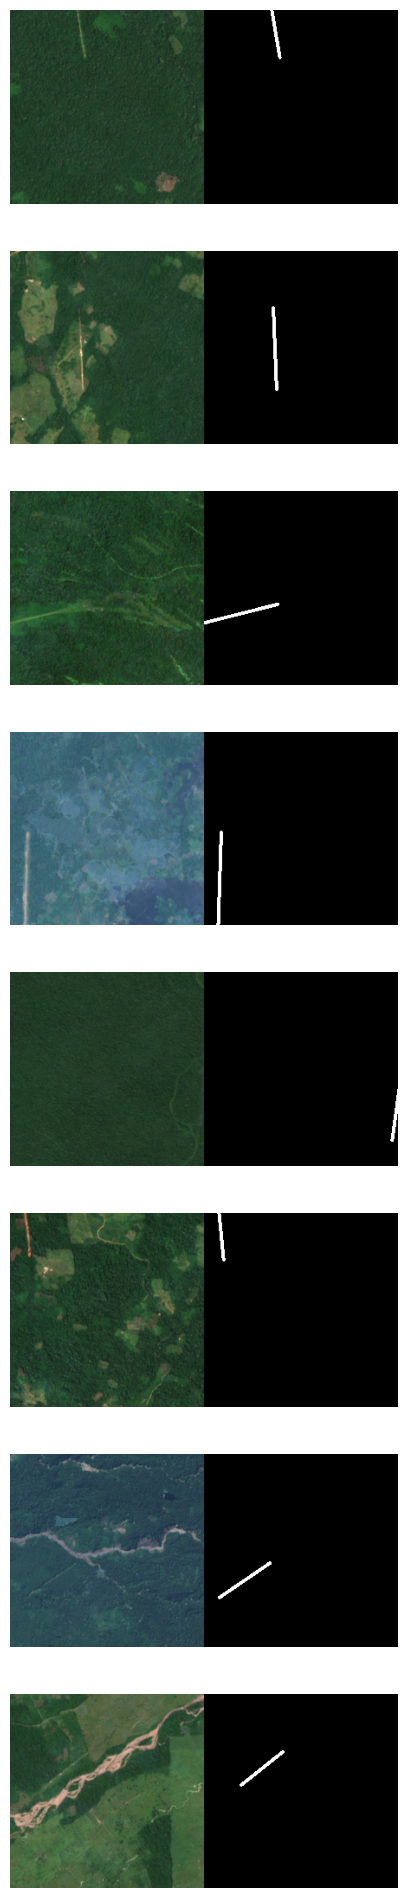

In [31]:
# You do not have to run this cell, It simply forces one iteration of the
# data loader (training) and plot the returned images and corresponding masks
# after image augmentation. This is a nice sanity check to make sure the mask
# and image still match...

imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]


images, masks = next(iter(train_loader))
fig, axes = plt.subplots(8, 2, figsize=(5, 25))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(8):
    image = images[i].permute(1, 2, 0).numpy()
    mask = masks[i].squeeze().numpy()

    #R_layer = image[:, :, 0]
    #G_layer = image[:, :, 1]
    #B_layer = image[:, :, 2]
    #print(f'R stats:  min:{R_layer.min()}, max:{R_layer.max()}, mean:{R_layer.mean()}, std:{R_layer.std()}')
    #print(f'G stats:  min:{G_layer.min()}, max:{G_layer.max()}, mean:{G_layer.mean()}, std:{G_layer.std()}')
    #print(f'B stats:  min:{B_layer.min()}, max:{B_layer.max()}, mean:{B_layer.mean()}, std:{B_layer.std()}')
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].axis('off')
plt.show()


## Instantiate the model

In [22]:
try:
    del model  # Try to delete the model
except NameError:
    pass  # If the model isn't defined, do nothing

In [23]:
model = get_model(in_channels=3).to(device)
torchsummary.summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 376MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Model Training and Evaluation

We can now proceed to model training and evaluation.

This section has three major parts:

Specify the criterion, optimizer, and hyperparameters (e.g.

1.   Specify the criterion, optimizer, and hyperparameters (e.g. n_epochs, learning rate, etc.).
2.   Train the model on the training set by updating its weights to minimize the loss function.
3.    Evaluate the model on the test set to observe performance on new, unseen data.
4.    Repeat steps 2 and 3 n_epochs times.

In [24]:
#criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([500], dtype=torch.float32).to(device))  # Binary cross-entropy loss
#criterion = FocalLoss(alpha=1, gamma=2)
criterion = DiceLoss()
#criterion = BCEDiceLoss()
#criterion = JaccardLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs = 100




We can now commence model training and evaluation in the following cell.

Epoch 1


100%|██████████| 11/11 [00:10<00:00,  1.00it/s]


Train Loss: 0.98; Accuracy: 31.83


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Val Loss: 0.99; Accuracy: 9.30
Average Jaccard Index (IoU): 0.0065
Epoch 2


100%|██████████| 11/11 [00:15<00:00,  1.36s/it]


Train Loss: 0.98; Accuracy: 65.15


100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Val Loss: 0.98; Accuracy: 64.85
Average Jaccard Index (IoU): 0.0282
Epoch 3


100%|██████████| 11/11 [00:12<00:00,  1.12s/it]


Train Loss: 0.98; Accuracy: 71.27


100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Val Loss: 0.97; Accuracy: 83.59
Average Jaccard Index (IoU): 0.1081
Epoch 4


100%|██████████| 11/11 [00:12<00:00,  1.18s/it]


Train Loss: 0.97; Accuracy: 77.96


100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Val Loss: 0.97; Accuracy: 77.50
Average Jaccard Index (IoU): 0.0470
Epoch 5


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Train Loss: 0.97; Accuracy: 81.66


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Val Loss: 0.97; Accuracy: 90.93
Average Jaccard Index (IoU): 0.1165
Epoch 6


100%|██████████| 11/11 [00:10<00:00,  1.06it/s]


Train Loss: 0.97; Accuracy: 85.59


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.94; Accuracy: 87.80
Average Jaccard Index (IoU): 0.2090
Epoch 7


100%|██████████| 11/11 [00:11<00:00,  1.09s/it]


Train Loss: 0.96; Accuracy: 88.64


100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Val Loss: 0.92; Accuracy: 88.13
Average Jaccard Index (IoU): 0.1097
Epoch 8


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


Train Loss: 0.94; Accuracy: 89.65


100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Val Loss: 0.93; Accuracy: 95.84
Average Jaccard Index (IoU): 0.3324
Epoch 9


100%|██████████| 11/11 [00:12<00:00,  1.17s/it]


Train Loss: 0.94; Accuracy: 89.07


100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


Val Loss: 0.96; Accuracy: 86.76
Average Jaccard Index (IoU): 0.0847
Epoch 10


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


Train Loss: 0.93; Accuracy: 88.43


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Val Loss: 0.85; Accuracy: 88.30
Average Jaccard Index (IoU): 0.2587
Epoch 11


100%|██████████| 11/11 [00:11<00:00,  1.09s/it]


Train Loss: 0.89; Accuracy: 85.77


100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


Val Loss: 0.87; Accuracy: 89.87
Average Jaccard Index (IoU): 0.1896
Epoch 12


100%|██████████| 11/11 [00:14<00:00,  1.33s/it]


Train Loss: 0.84; Accuracy: 83.28


100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Val Loss: 0.78; Accuracy: 93.37
Average Jaccard Index (IoU): 0.3535
Epoch 13


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


Train Loss: 0.80; Accuracy: 84.95


100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Val Loss: 0.87; Accuracy: 89.40
Average Jaccard Index (IoU): 0.1787
Epoch 14


100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


Train Loss: 0.78; Accuracy: 87.37


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Val Loss: 0.68; Accuracy: 96.35
Average Jaccard Index (IoU): 0.3303
Epoch 15


100%|██████████| 11/11 [00:10<00:00,  1.06it/s]


Train Loss: 0.72; Accuracy: 86.70


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Val Loss: 0.63; Accuracy: 95.07
Average Jaccard Index (IoU): 0.3325
Epoch 16


100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Train Loss: 0.71; Accuracy: 88.87


100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Val Loss: 0.59; Accuracy: 98.13
Average Jaccard Index (IoU): 0.3692
Epoch 17


100%|██████████| 11/11 [00:13<00:00,  1.19s/it]


Train Loss: 0.71; Accuracy: 95.11


100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Val Loss: 0.56; Accuracy: 91.76
Average Jaccard Index (IoU): 0.3548
Epoch 18


100%|██████████| 11/11 [00:12<00:00,  1.17s/it]


Train Loss: 0.68; Accuracy: 93.05


100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


Val Loss: 0.62; Accuracy: 97.27
Average Jaccard Index (IoU): 0.3092
Epoch 19


100%|██████████| 11/11 [00:11<00:00,  1.00s/it]


Train Loss: 0.71; Accuracy: 93.58


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Val Loss: 0.95; Accuracy: 32.17
Average Jaccard Index (IoU): 0.0307
Epoch 20


100%|██████████| 11/11 [00:10<00:00,  1.06it/s]


Train Loss: 0.67; Accuracy: 93.85


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Val Loss: 0.65; Accuracy: 99.45
Average Jaccard Index (IoU): 0.2974
Epoch 21


100%|██████████| 11/11 [00:12<00:00,  1.16s/it]


Train Loss: 0.67; Accuracy: 95.87


100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


Val Loss: 0.52; Accuracy: 99.12
Average Jaccard Index (IoU): 0.3848
Epoch 22


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


Train Loss: 0.65; Accuracy: 98.88


100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


Val Loss: 0.56; Accuracy: 99.42
Average Jaccard Index (IoU): 0.3730
Epoch 23


100%|██████████| 11/11 [00:11<00:00,  1.06s/it]


Train Loss: 0.58; Accuracy: 99.17


100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


Val Loss: 0.65; Accuracy: 99.54
Average Jaccard Index (IoU): 0.2994
Epoch 24


100%|██████████| 11/11 [00:10<00:00,  1.06it/s]


Train Loss: 0.58; Accuracy: 99.06


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.59; Accuracy: 99.40
Average Jaccard Index (IoU): 0.3535
Epoch 25


100%|██████████| 11/11 [00:12<00:00,  1.09s/it]


Train Loss: 0.59; Accuracy: 99.18


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


Val Loss: 0.61; Accuracy: 98.75
Average Jaccard Index (IoU): 0.3563
Epoch 26


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


Train Loss: 0.54; Accuracy: 99.19


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Val Loss: 0.49; Accuracy: 99.59
Average Jaccard Index (IoU): 0.4430
Epoch 27


100%|██████████| 11/11 [00:13<00:00,  1.19s/it]


Train Loss: 0.54; Accuracy: 99.18


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


Val Loss: 0.57; Accuracy: 99.26
Average Jaccard Index (IoU): 0.3259
Epoch 28


100%|██████████| 11/11 [00:11<00:00,  1.08s/it]


Train Loss: 0.50; Accuracy: 99.29


100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


Val Loss: 0.48; Accuracy: 99.45
Average Jaccard Index (IoU): 0.4368
Epoch 29


100%|██████████| 11/11 [00:10<00:00,  1.06it/s]


Train Loss: 0.52; Accuracy: 99.37


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.59; Accuracy: 99.20
Average Jaccard Index (IoU): 0.3239
Epoch 30


100%|██████████| 11/11 [00:14<00:00,  1.36s/it]


Train Loss: 0.51; Accuracy: 99.17


100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


Val Loss: 0.56; Accuracy: 99.34
Average Jaccard Index (IoU): 0.3300
Epoch 31


100%|██████████| 11/11 [00:12<00:00,  1.09s/it]


Train Loss: 0.46; Accuracy: 99.44


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


Val Loss: 0.46; Accuracy: 99.47
Average Jaccard Index (IoU): 0.4430
Epoch 32


100%|██████████| 11/11 [00:13<00:00,  1.18s/it]


Train Loss: 0.53; Accuracy: 99.21


100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


Val Loss: 0.53; Accuracy: 99.53
Average Jaccard Index (IoU): 0.3649
Epoch 33


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Train Loss: 0.50; Accuracy: 99.43


100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


Val Loss: 0.45; Accuracy: 99.28
Average Jaccard Index (IoU): 0.4495
Epoch 34


100%|██████████| 11/11 [00:10<00:00,  1.04it/s]


Train Loss: 0.52; Accuracy: 99.25


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Val Loss: 0.78; Accuracy: 99.17
Average Jaccard Index (IoU): 0.1535
Epoch 35


100%|██████████| 11/11 [00:10<00:00,  1.03it/s]


Train Loss: 0.46; Accuracy: 99.31


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Val Loss: 0.49; Accuracy: 99.18
Average Jaccard Index (IoU): 0.4021
Epoch 36


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


Train Loss: 0.50; Accuracy: 99.33


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


Val Loss: 0.55; Accuracy: 99.43
Average Jaccard Index (IoU): 0.3642
Epoch 37


100%|██████████| 11/11 [00:12<00:00,  1.18s/it]


Train Loss: 0.47; Accuracy: 99.43


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


Val Loss: 0.59; Accuracy: 99.49
Average Jaccard Index (IoU): 0.3418
Epoch 38


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


Train Loss: 0.47; Accuracy: 99.36


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


Val Loss: 0.83; Accuracy: 99.14
Average Jaccard Index (IoU): 0.1795
Epoch 39


100%|██████████| 11/11 [00:10<00:00,  1.02it/s]


Train Loss: 0.49; Accuracy: 99.31


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.58; Accuracy: 99.53
Average Jaccard Index (IoU): 0.3298
Epoch 40


100%|██████████| 11/11 [00:10<00:00,  1.06it/s]


Train Loss: 0.46; Accuracy: 99.44


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Val Loss: 0.60; Accuracy: 99.43
Average Jaccard Index (IoU): 0.3091
Epoch 41


100%|██████████| 11/11 [00:14<00:00,  1.33s/it]


Train Loss: 0.47; Accuracy: 99.35


100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Val Loss: 0.49; Accuracy: 99.46
Average Jaccard Index (IoU): 0.4031
Epoch 42


100%|██████████| 11/11 [00:12<00:00,  1.17s/it]


Train Loss: 0.46; Accuracy: 99.24


100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Val Loss: 0.74; Accuracy: 99.26
Average Jaccard Index (IoU): 0.2045
Epoch 43


100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


Train Loss: 0.50; Accuracy: 99.50


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Val Loss: 0.46; Accuracy: 99.48
Average Jaccard Index (IoU): 0.4501
Epoch 44


100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


Train Loss: 0.44; Accuracy: 99.33


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Val Loss: 0.50; Accuracy: 99.49
Average Jaccard Index (IoU): 0.4043
Epoch 45


100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


Train Loss: 0.45; Accuracy: 99.48


100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Val Loss: 0.43; Accuracy: 99.63
Average Jaccard Index (IoU): 0.4767
Epoch 46


100%|██████████| 11/11 [00:12<00:00,  1.18s/it]


Train Loss: 0.46; Accuracy: 99.46


100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Val Loss: 0.56; Accuracy: 99.46
Average Jaccard Index (IoU): 0.3535
Epoch 47


100%|██████████| 11/11 [00:12<00:00,  1.17s/it]


Train Loss: 0.47; Accuracy: 99.37


100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Val Loss: 0.66; Accuracy: 99.07
Average Jaccard Index (IoU): 0.2615
Epoch 48


100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


Train Loss: 0.43; Accuracy: 99.39


100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Val Loss: 0.48; Accuracy: 99.44
Average Jaccard Index (IoU): 0.4079
Epoch 49


100%|██████████| 11/11 [00:10<00:00,  1.06it/s]


Train Loss: 0.45; Accuracy: 99.47


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.46; Accuracy: 99.67
Average Jaccard Index (IoU): 0.4241
Epoch 50


100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


Train Loss: 0.43; Accuracy: 99.43


100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Val Loss: 0.45; Accuracy: 99.61
Average Jaccard Index (IoU): 0.4606
Epoch 51


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


Train Loss: 0.44; Accuracy: 99.48


100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Val Loss: 0.51; Accuracy: 99.37
Average Jaccard Index (IoU): 0.3993
Epoch 52


100%|██████████| 11/11 [00:12<00:00,  1.18s/it]


Train Loss: 0.45; Accuracy: 99.46


100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


Val Loss: 0.46; Accuracy: 99.41
Average Jaccard Index (IoU): 0.4464
Epoch 53


100%|██████████| 11/11 [00:11<00:00,  1.01s/it]


Train Loss: 0.42; Accuracy: 99.43


100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


Val Loss: 0.53; Accuracy: 99.48
Average Jaccard Index (IoU): 0.3857
Epoch 54


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


Train Loss: 0.48; Accuracy: 99.51


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Val Loss: 0.68; Accuracy: 99.49
Average Jaccard Index (IoU): 0.2428
Epoch 55


100%|██████████| 11/11 [00:15<00:00,  1.37s/it]


Train Loss: 0.47; Accuracy: 99.45


100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


Val Loss: 0.61; Accuracy: 99.56
Average Jaccard Index (IoU): 0.3372
Epoch 56


100%|██████████| 11/11 [00:12<00:00,  1.12s/it]


Train Loss: 0.45; Accuracy: 99.41


100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Val Loss: 0.44; Accuracy: 99.41
Average Jaccard Index (IoU): 0.4608
Epoch 57


100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


Train Loss: 0.42; Accuracy: 99.39


100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


Val Loss: 0.49; Accuracy: 99.56
Average Jaccard Index (IoU): 0.4432
Epoch 58


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


Train Loss: 0.41; Accuracy: 99.42


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Val Loss: 0.48; Accuracy: 99.30
Average Jaccard Index (IoU): 0.3940
Epoch 59


100%|██████████| 11/11 [00:10<00:00,  1.04it/s]


Train Loss: 0.41; Accuracy: 99.51


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.48; Accuracy: 99.64
Average Jaccard Index (IoU): 0.4137
Epoch 60


100%|██████████| 11/11 [00:11<00:00,  1.04s/it]


Train Loss: 0.46; Accuracy: 99.46


100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Val Loss: 0.50; Accuracy: 99.40
Average Jaccard Index (IoU): 0.4237
Epoch 61


100%|██████████| 11/11 [00:12<00:00,  1.16s/it]


Train Loss: 0.44; Accuracy: 99.39


100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


Val Loss: 0.52; Accuracy: 99.56
Average Jaccard Index (IoU): 0.3941
Epoch 62


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Train Loss: 0.44; Accuracy: 99.50


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Val Loss: 0.59; Accuracy: 99.56
Average Jaccard Index (IoU): 0.3286
Epoch 63


100%|██████████| 11/11 [00:11<00:00,  1.03s/it]


Train Loss: 0.47; Accuracy: 99.41


100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Val Loss: 0.48; Accuracy: 99.52
Average Jaccard Index (IoU): 0.4186
Epoch 64


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


Train Loss: 0.44; Accuracy: 99.47


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Val Loss: 0.57; Accuracy: 99.29
Average Jaccard Index (IoU): 0.3485
Epoch 65


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Train Loss: 0.43; Accuracy: 99.45


100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


Val Loss: 0.45; Accuracy: 99.54
Average Jaccard Index (IoU): 0.4536
Epoch 66


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Train Loss: 0.42; Accuracy: 99.52


100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


Val Loss: 0.34; Accuracy: 99.62
Average Jaccard Index (IoU): 0.5513
Epoch 67


100%|██████████| 11/11 [00:12<00:00,  1.17s/it]


Train Loss: 0.44; Accuracy: 99.49


100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


Val Loss: 0.54; Accuracy: 99.46
Average Jaccard Index (IoU): 0.3715
Epoch 68


100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


Train Loss: 0.41; Accuracy: 99.47


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Val Loss: 0.41; Accuracy: 99.39
Average Jaccard Index (IoU): 0.4707
Epoch 69


100%|██████████| 11/11 [00:11<00:00,  1.08s/it]


Train Loss: 0.39; Accuracy: 99.45


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Val Loss: 0.42; Accuracy: 99.60
Average Jaccard Index (IoU): 0.4900
Epoch 70


100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


Train Loss: 0.38; Accuracy: 99.56


100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


Val Loss: 0.47; Accuracy: 99.52
Average Jaccard Index (IoU): 0.4376
Epoch 71


100%|██████████| 11/11 [00:13<00:00,  1.18s/it]


Train Loss: 0.38; Accuracy: 99.53


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


Val Loss: 0.43; Accuracy: 99.60
Average Jaccard Index (IoU): 0.4760
Epoch 72


100%|██████████| 11/11 [00:13<00:00,  1.19s/it]


Train Loss: 0.43; Accuracy: 99.47


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 0.53; Accuracy: 99.44
Average Jaccard Index (IoU): 0.3751
Epoch 73


100%|██████████| 11/11 [00:14<00:00,  1.32s/it]


Train Loss: 0.38; Accuracy: 99.56


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


Val Loss: 0.40; Accuracy: 99.49
Average Jaccard Index (IoU): 0.4681
Epoch 74


100%|██████████| 11/11 [00:10<00:00,  1.01it/s]


Train Loss: 0.41; Accuracy: 99.48


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Val Loss: 0.45; Accuracy: 99.53
Average Jaccard Index (IoU): 0.4411
Epoch 75


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


Train Loss: 0.40; Accuracy: 99.50


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Val Loss: 0.45; Accuracy: 99.47
Average Jaccard Index (IoU): 0.4486
Epoch 76


100%|██████████| 11/11 [00:12<00:00,  1.16s/it]


Train Loss: 0.43; Accuracy: 99.55


100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Val Loss: 0.48; Accuracy: 99.65
Average Jaccard Index (IoU): 0.4401
Epoch 77


100%|██████████| 11/11 [00:12<00:00,  1.18s/it]


Train Loss: 0.36; Accuracy: 99.51


100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Val Loss: 0.41; Accuracy: 99.66
Average Jaccard Index (IoU): 0.4990
Epoch 78


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Train Loss: 0.40; Accuracy: 99.49


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Val Loss: 0.54; Accuracy: 99.53
Average Jaccard Index (IoU): 0.3720
Epoch 79


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


Train Loss: 0.39; Accuracy: 99.52


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.35; Accuracy: 99.63
Average Jaccard Index (IoU): 0.5328
Epoch 80


100%|██████████| 11/11 [00:11<00:00,  1.09s/it]


Train Loss: 0.40; Accuracy: 99.54


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


Val Loss: 0.41; Accuracy: 99.59
Average Jaccard Index (IoU): 0.4701
Epoch 81


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


Train Loss: 0.36; Accuracy: 99.56


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


Val Loss: 0.51; Accuracy: 99.55
Average Jaccard Index (IoU): 0.4066
Epoch 82


100%|██████████| 11/11 [00:13<00:00,  1.19s/it]


Train Loss: 0.38; Accuracy: 99.49


100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


Val Loss: 0.47; Accuracy: 99.41
Average Jaccard Index (IoU): 0.4389
Epoch 83


100%|██████████| 11/11 [00:11<00:00,  1.08s/it]


Train Loss: 0.38; Accuracy: 99.57


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Val Loss: 0.55; Accuracy: 99.58
Average Jaccard Index (IoU): 0.3856
Epoch 84


100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


Train Loss: 0.42; Accuracy: 99.55


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Val Loss: 0.52; Accuracy: 99.48
Average Jaccard Index (IoU): 0.3925
Epoch 85


100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


Train Loss: 0.39; Accuracy: 99.51


100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Val Loss: 0.52; Accuracy: 99.45
Average Jaccard Index (IoU): 0.3821
Epoch 86


100%|██████████| 11/11 [00:12<00:00,  1.18s/it]


Train Loss: 0.38; Accuracy: 99.56


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Val Loss: 0.41; Accuracy: 99.64
Average Jaccard Index (IoU): 0.4842
Epoch 87


100%|██████████| 11/11 [00:15<00:00,  1.42s/it]


Train Loss: 0.36; Accuracy: 99.52


100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Val Loss: 0.51; Accuracy: 99.53
Average Jaccard Index (IoU): 0.3725
Epoch 88


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Train Loss: 0.38; Accuracy: 99.57


100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Val Loss: 0.47; Accuracy: 99.55
Average Jaccard Index (IoU): 0.4321
Epoch 89


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


Train Loss: 0.38; Accuracy: 99.57


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 0.36; Accuracy: 99.64
Average Jaccard Index (IoU): 0.5389
Epoch 90


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Train Loss: 0.41; Accuracy: 99.55


100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


Val Loss: 0.43; Accuracy: 99.62
Average Jaccard Index (IoU): 0.4654
Epoch 91


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Train Loss: 0.34; Accuracy: 99.59


100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Val Loss: 0.41; Accuracy: 99.58
Average Jaccard Index (IoU): 0.4816
Epoch 92


100%|██████████| 11/11 [00:13<00:00,  1.18s/it]


Train Loss: 0.39; Accuracy: 99.60


100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Val Loss: 0.48; Accuracy: 99.52
Average Jaccard Index (IoU): 0.4222
Epoch 93


100%|██████████| 11/11 [00:11<00:00,  1.00s/it]


Train Loss: 0.34; Accuracy: 99.55


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Val Loss: 0.49; Accuracy: 99.58
Average Jaccard Index (IoU): 0.4277
Epoch 94


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


Train Loss: 0.40; Accuracy: 99.54


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Val Loss: 0.40; Accuracy: 99.67
Average Jaccard Index (IoU): 0.5106
Epoch 95


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Train Loss: 0.42; Accuracy: 99.54


100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


Val Loss: 0.40; Accuracy: 99.61
Average Jaccard Index (IoU): 0.4733
Epoch 96


100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


Train Loss: 0.40; Accuracy: 99.50


100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


Val Loss: 0.43; Accuracy: 99.63
Average Jaccard Index (IoU): 0.4628
Epoch 97


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Train Loss: 0.40; Accuracy: 99.51


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Val Loss: 0.44; Accuracy: 99.53
Average Jaccard Index (IoU): 0.4788
Epoch 98


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


Train Loss: 0.41; Accuracy: 99.48


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Val Loss: 0.44; Accuracy: 99.57
Average Jaccard Index (IoU): 0.4734
Epoch 99


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


Train Loss: 0.36; Accuracy: 99.52


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Val Loss: 0.39; Accuracy: 99.62
Average Jaccard Index (IoU): 0.4989
Epoch 100


100%|██████████| 11/11 [00:11<00:00,  1.07s/it]


Train Loss: 0.40; Accuracy: 99.54


100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Val Loss: 0.48; Accuracy: 99.58
Average Jaccard Index (IoU): 0.4204


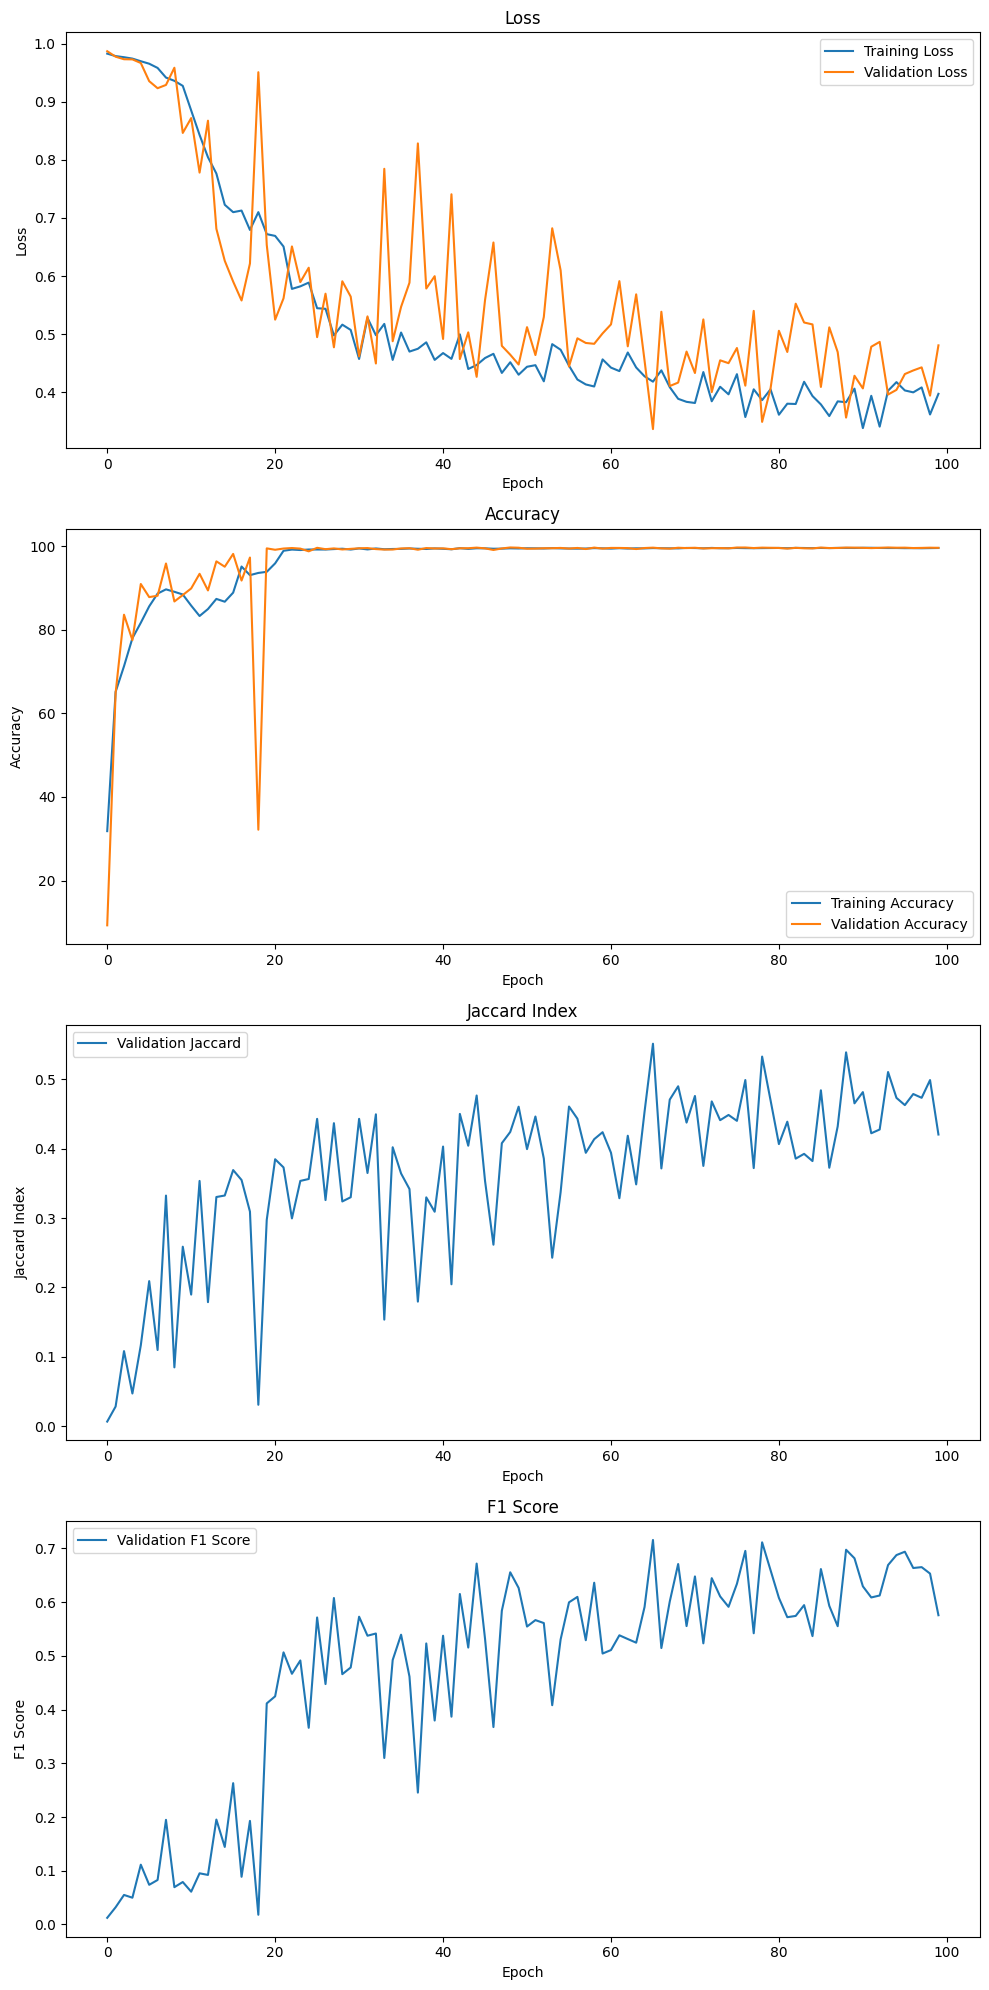

In [25]:
best_model = fit(model, train_loader, val_loader, epochs, criterion=criterion, optimizer=optimizer, device=device)

# Training loop
#for epoch in range(epochs):
#    print(f"Epoch {epoch+1}/{epochs}")
#    train_model(model, train_loader, criterion, optimizer, device)


#for epoch in range(epochs):
#    print(f"Epoch {epoch+1}/{epochs}")
#    train_model(model, train_loader, criterion, optimizer, device)


## Model Performance on the Test Set

Using the best model from the previous steps, we can evaluate the model performance on the test set.

  0%|          | 0/2 [00:00<?, ?it/s]

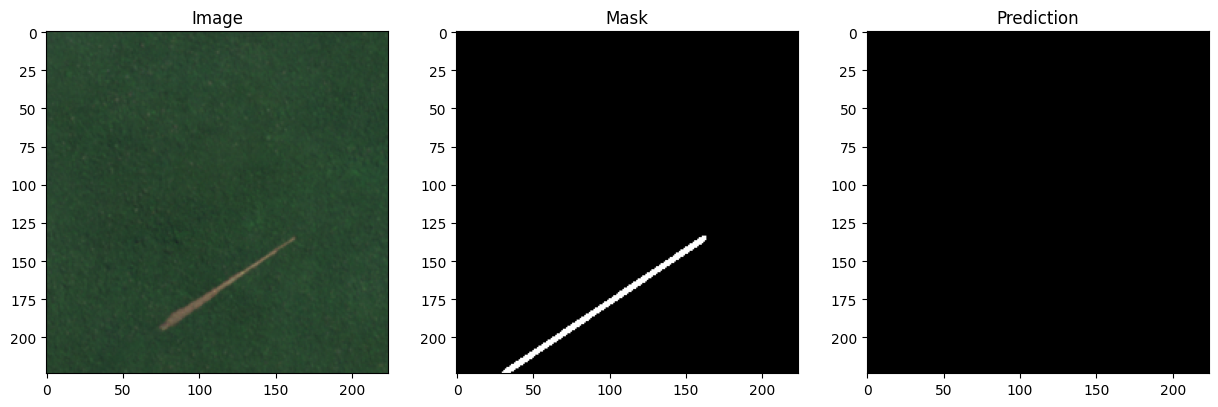

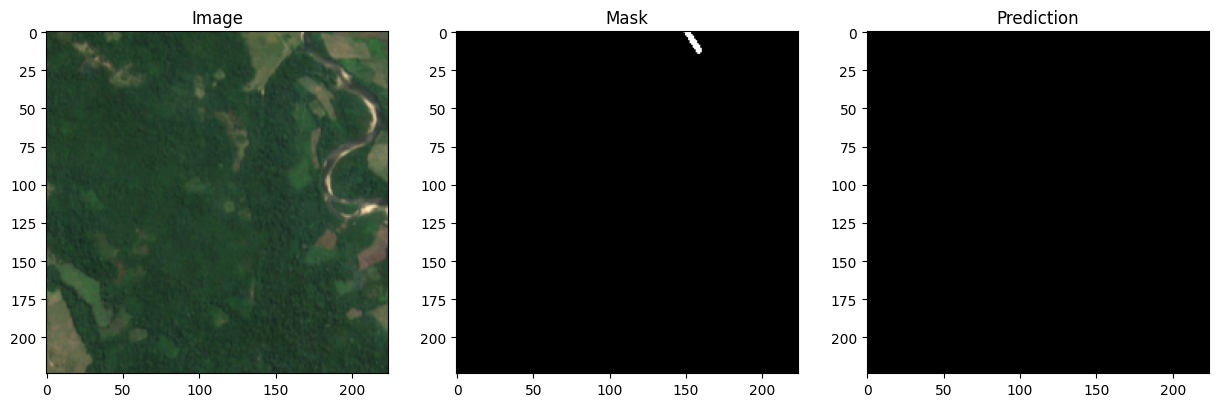

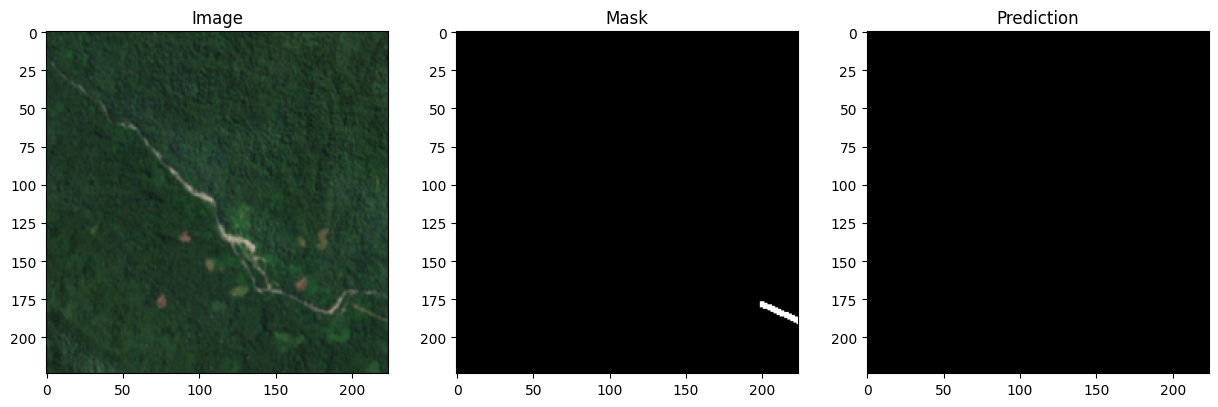

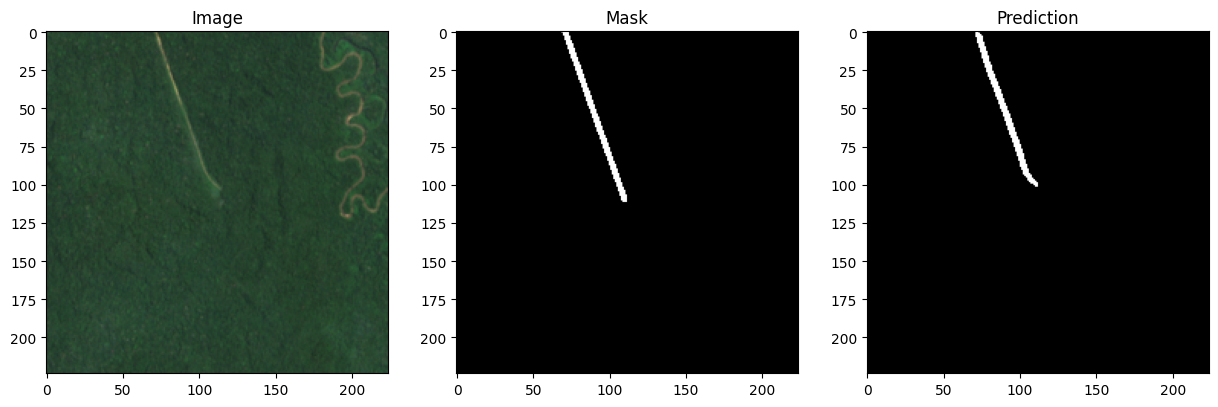

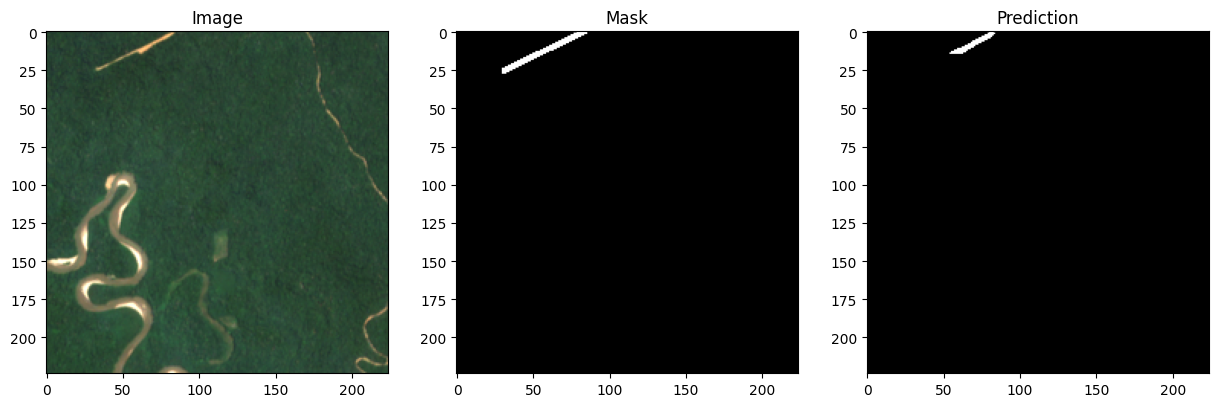

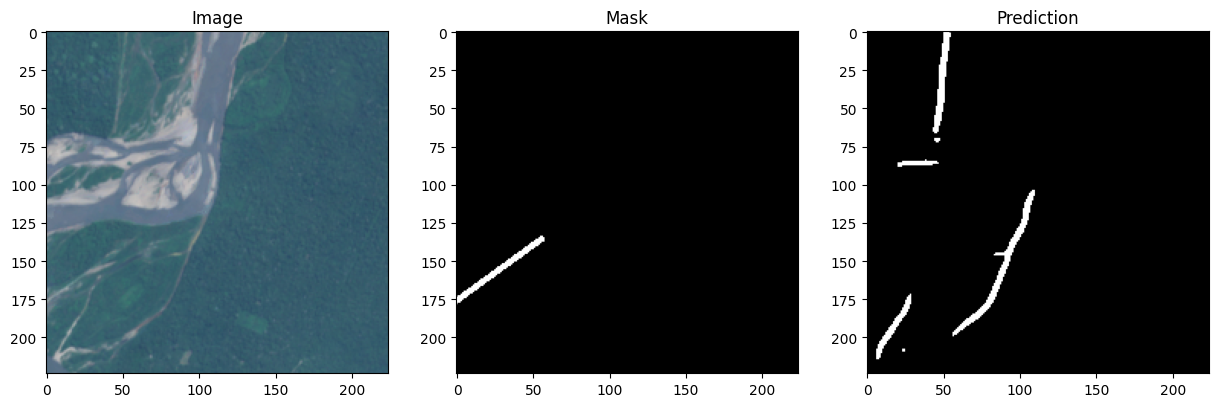

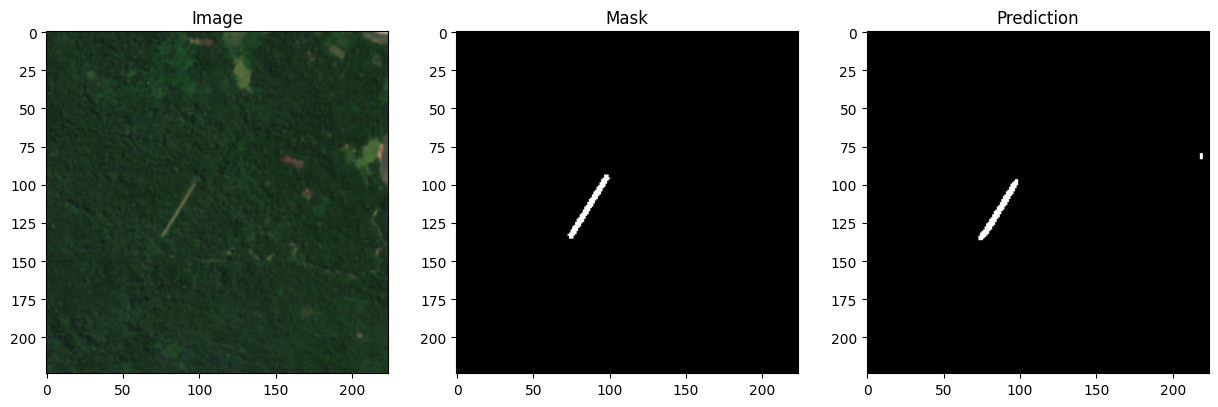

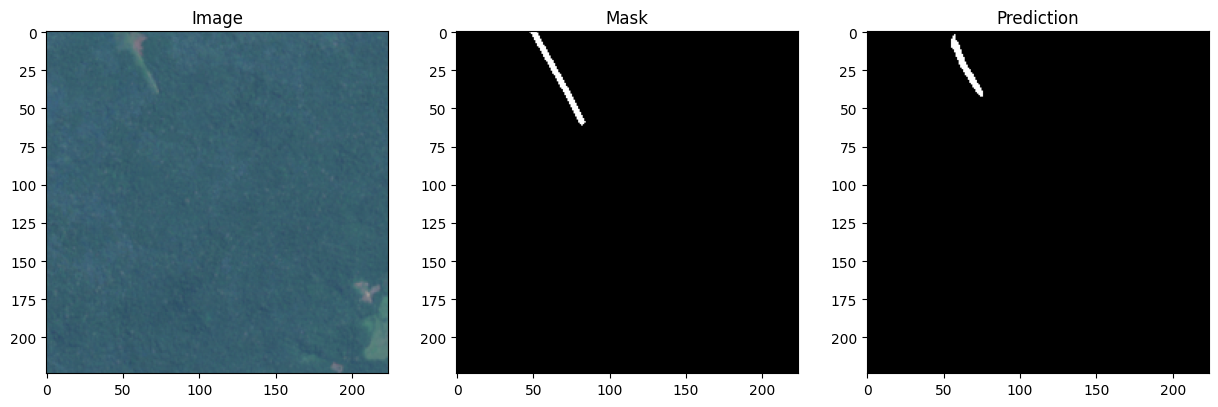

 50%|█████     | 1/2 [00:08<00:08,  8.98s/it]

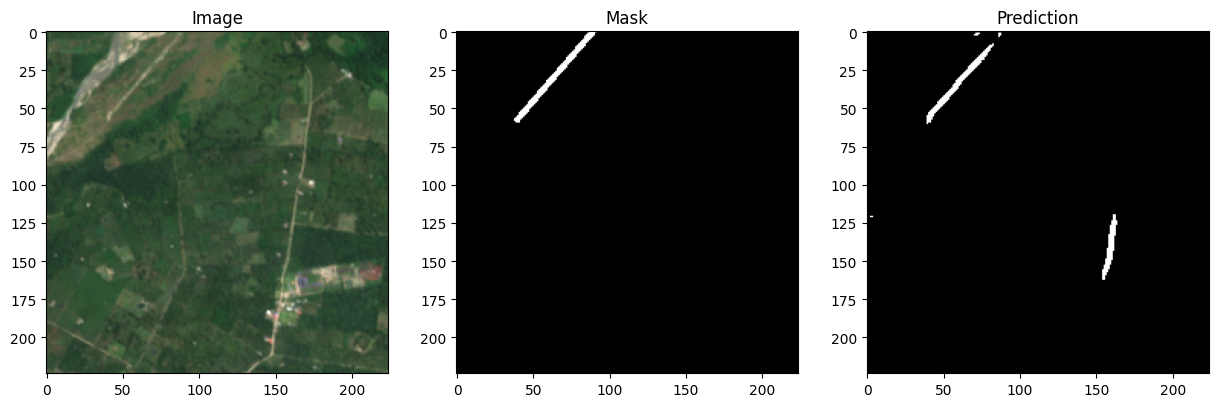

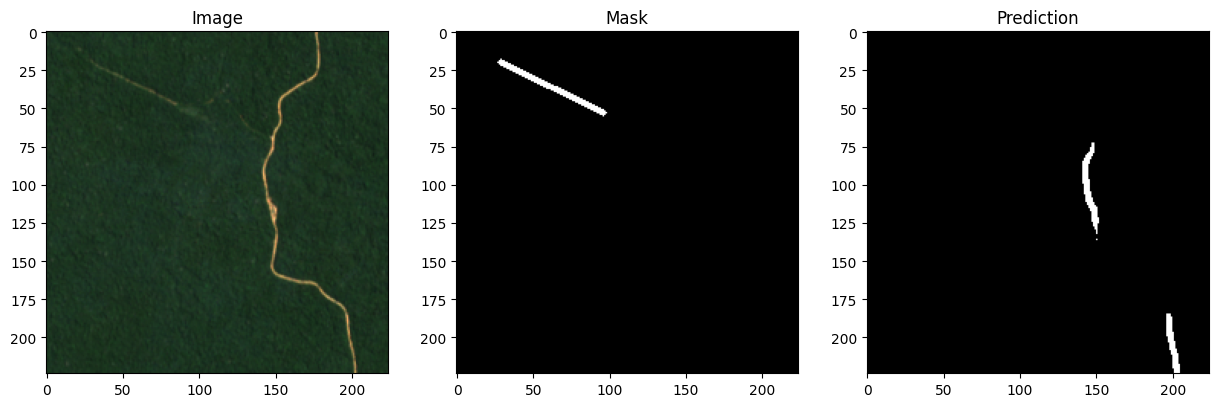

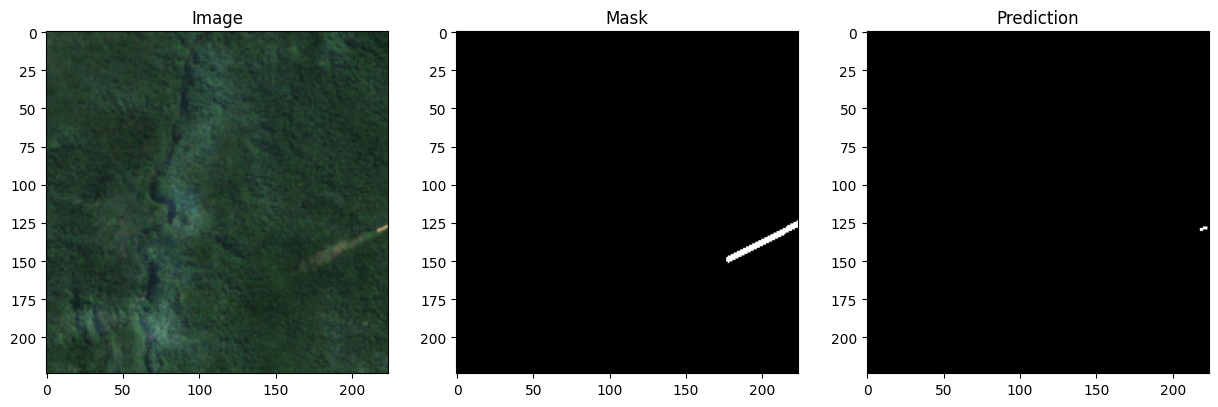

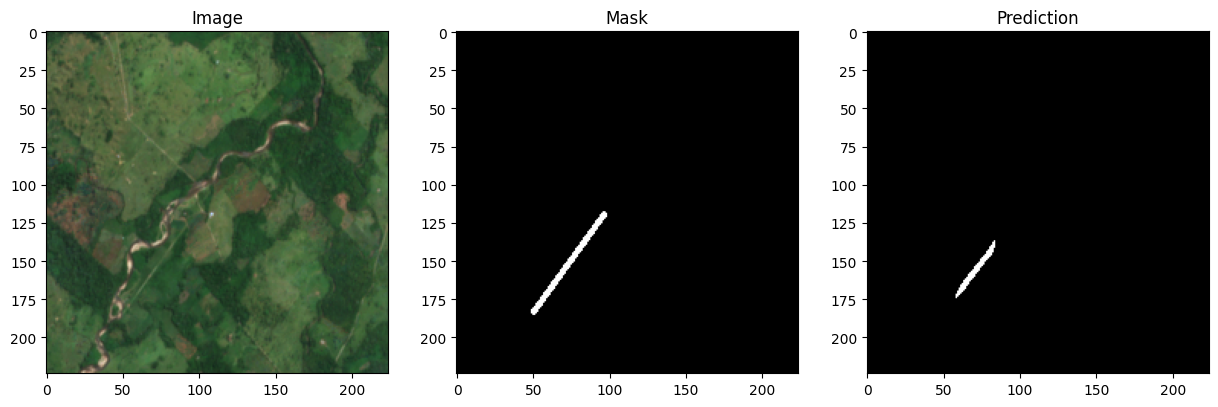

100%|██████████| 2/2 [00:11<00:00,  5.83s/it]

Test Loss: 0.67; Accuracy: 99.31
Average Jaccard Index (IoU): 0.2482


In [26]:
test_loss = evaluate(best_model, test_loader, criterion, device=device, phase="test", plot=True)

## Save Model

Let's define a function for saving the model to our local Google drive as follows.

In [78]:
model_dir = "/content/drive/My Drive/Colab Notebooks/models/"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = os.path.join(model_dir, 'zindi_best_model_20241025_200m_lr0005.pth')
model_file

'/content/drive/My Drive/Colab Notebooks/models/zindi_best_model_20241025_200m_lr0005.pth'

In [68]:
def save_model(best_model, model_file):
  torch.save(best_model.state_dict(), model_file)
  print('Model successfully saved to {}.'.format(model_file))

In [79]:
save_model(best_model, model_file)

Model successfully saved to /content/drive/My Drive/Colab Notebooks/models/zindi_best_model_20241025_200m_lr0005.pth.


## Visualization of the model prediction

Let's load the model, create a data loader for the entire dataset only with center cropping, get a prediction, and plot the results using an animated GIF. This could be useful for identifying issues with different models.

In [94]:
try:
    del model  # Try to delete the model
except NameError:
    pass  # If the model isn't defined, do nothing

# Load the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model().to(device)
model_path = '/content/drive/MyDrive/Zindi-Amazon/models/zindi_best_model_20241028_200m_lr0005.pth'
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()


<ipython-input-94-3124e189bdfa>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [95]:
image_dir = '/content/images'
mask_dir = '/content/masks_200m'
output_gif = 'Inference_200m.gif'

# Navigate to the base directory
%cd /content/


# List image and mask file paths
image_paths = [os.path.join(image_dir, img) for img in sorted(os.listdir(image_dir)) if img.endswith('.tif')]
mask_paths = [os.path.join(mask_dir, mask) for mask in sorted(os.listdir(mask_dir)) if mask.endswith('.tif')]

inference_data =  Sentinel2Dataset(image_paths=image_paths, mask_paths=mask_paths, transform=get_augmentations(option='inference'))

batch_size = 8
num_workers = 2

inference_loader = DataLoader(inference_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)


imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
animation_images = []

for i, (images, masks) in enumerate(inference_loader):
    images = images.to(device)
    masks = masks.to(device)

    # Add channel dimension to the target masks
    masks = masks.type(torch.float32)
    masks = masks.unsqueeze(1)


    with torch.set_grad_enabled(False):
        outputs = model(images)
        loss = criterion(outputs, masks)
        # Apply sigmoid to the outputs (for binary segmentation) and threshold
        preds = torch.sigmoid(outputs) > 0.5


    # Plot image, mask, and prediction for a sample in the batch
    for j in range(images.shape[0]):  # Loop through batch
        image = images[j].cpu().permute(1, 2, 0).numpy()  # Move to CPU, permute for plotting
        image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)
        mask = masks[j].cpu().squeeze().numpy()
        prediction = outputs[j].cpu().squeeze()

        # Apply sigmoid for binary segmentation if your model output is logits.
        prediction = torch.sigmoid(prediction)

        # Threshold predictions (adjust threshold as needed)
        prediction = (prediction > 0.5).float().numpy()  # Example threshold of 0.5

        #plot_predictions(image, mask, prediction) # Call plot function
        """Plots the image, mask, and prediction side-by-side."""
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        ax1.imshow(image)
        ax1.set_title("Image")
        ax2.imshow(mask, cmap='gray')
        ax2.set_title("Mask")
        ax3.imshow(prediction, cmap='gray')
        ax3.set_title("Prediction")
        #plt.show()
        temp_file = 'temp_plot.png'
        plt.savefig(temp_file)
        plt.close()
        animation_images.append(imageio.imread(temp_file))
        os.remove(temp_file)

imageio.mimsave(output_gif, animation_images, fps=0.5)









/content


<ipython-input-95-64a912fa00f1>:66: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  animation_images.append(imageio.imread(temp_file))


In [31]:
### DON'T USE
def check_geotiffs_for_nan(images_dir):
    """Checks all GeoTIFF files in the images directory for NaN values in any band."""

    for filename in os.listdir(images_dir):
        if filename.endswith(".tif"):
            filepath = os.path.join(images_dir, filename)
            with rasterio.open(filepath) as src:
                for band_index in range(1, src.count + 1):  # Iterate over bands
                    band_data = src.read(band_index)
                    if np.isnan(band_data).any():
                        print(f"Found NaN values in {filename}, band {band_index}")
    return  # Stop after finding the first NaN value (optional)

In [32]:
images_dir = '/content/images'  # Replace with your images directory
check_geotiffs_for_nan(images_dir)

Found NaN values in Sentinel_AllBands_Training_Id_140.tif, band 1
Found NaN values in Sentinel_AllBands_Training_Id_140.tif, band 2
Found NaN values in Sentinel_AllBands_Training_Id_140.tif, band 3
Found NaN values in Sentinel_AllBands_Training_Id_140.tif, band 4
Found NaN values in Sentinel_AllBands_Training_Id_140.tif, band 5
Found NaN values in Sentinel_AllBands_Training_Id_140.tif, band 6
